In [28]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *




# Load Dataset

In [4]:
cs_df = pd.read_excel('Online Retail.xlsx')

In [8]:
cs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
cs_df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2      2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
...                    ...        ...         ...             ...  
541904 2011-12-09 12:50:00       0.85     12680.0          France  
541905 2011-12-09 12:50:00       2.10     12680.0          France  
541906 2011-12-09 12:50:00       4.15     12680.0          France  
541907 2011-12-09 12:50:00       4.15     12680.0          France  
541908 2011-12-09 12:50:00       4.95     12680.0          France  

[541909 rows x 8 columns]

# Exploratory Data Analysis (EDA)

Saya membuat fungsi di bawah ini untuk menyederhanakan analisis karakteristik umum data. Terinspirasi pada fungsi str dari R, fungsi ini mengembalikan jenis, jumlah, perbedaan, jumlah nol, rasio yang hilang, dan nilai unik dari setiap bidang/fitur.

Jika studi melibatkan beberapa pembelajaran yang diawasi, fungsi ini dapat mengembalikan studi korelasi, untuk ini kita hanya perlu memberikan variabel dependen ke parameter sebelumnya.

Juga, jika pengembaliannya disimpan dalam variabel, Anda dapat mengevaluasinya secara lebih rinci, fokus pada bidang tertentu, atau mengurutkannya dari perspektif yang berbeda.

In [10]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: x.unique())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1, sort=True)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=True)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

details = rstr(cs_df)
display(details.sort_values(by='missing ration', ascending=False))

Data shape: (541909, 8)
___________________________
Data types:
 object            4
float64           2
datetime64[ns]    1
int64             1
Name: types, dtype: int64
___________________________


types  counts  distincts   nulls  missing ration  \
CustomerID          float64  406829       4373  135080       24.926694   
Description          object  540455       4224    1454        0.268311   
Country              object  541909         38       0        0.000000   
InvoiceDate  datetime64[ns]  541909      23260       0        0.000000   
InvoiceNo            object  541909      25900       0        0.000000   
Quantity              int64  541909        722       0        0.000000   
StockCode            object  541909       4070       0        0.000000   
UnitPrice           float64  541909       1630       0        0.000000   

                                                       uniques    skewness  \
CustomerID   [17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...    0.029835   
Description  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...         NaN   
Country      [United Kingdom, France, Australia, Netherland...         NaN   
InvoiceDate  [2010-12-01T08:26:00.000000000, 2010-12-01T08:...         NaN   
InvoiceNo    [536365, 536366, 536367, 536368, 536369, 53637...         NaN   
Quantity     [6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...   -0.264076   
StockCode    [85123A, 71053, 84406B, 84029G, 84029E, 22752,...         NaN   
UnitPrice    [2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...  186.506972   

                  kurtosis  
CustomerID       -1.179982  
Description            NaN  
Country                NaN  
InvoiceDate            NaN  
InvoiceNo              NaN  
Quantity     119769.160031  
StockCode              NaN  
UnitPrice     59005.719097

Mari kita lihat deskripsi masing-masing kolom:

+ InvoiceNo: A unique identifier for the invoice. An invoice number shared across rows means that those transactions were performed in a single invoice (multiple purchases).
+ StockCode: Identifier for items contained in an invoice.
+ Description: Textual description of each of the stock item.
+ Quantity: The quantity of the item purchased.
+ InvoiceDate: Date of purchase.
+ UnitPrice: Value of each item.
+ CustomerID: Identifier for customer making the purchase.
+ Country: Country of customer.

In [11]:
cs_df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

Kita dapat mengamati dari output sebelumnya bahwa Quantity dan UnitPrice memiliki nilai negatif, yang dapat berarti bahwa kita mungkin juga memiliki beberapa transaksi pengembalian dalam data kita. Karena tujuan kami adalah segmentasi pelanggan dan analisis keranjang pasar, penting untuk menghapus catatan ini, tetapi pertama-tama kita akan melihat apakah ada catatan di mana keduanya negatif atau jika salah satunya negatif dan yang lainnya nol.

In [15]:
print('Periksa apakah kami memiliki kuantitas dan harga negatif pada register yang sama:',
     'No' if cs_df[(cs_df.Quantity<0) & (cs_df.UnitPrice<0)].shape[0] == 0 else 'Yes', '\n')
print('Periksa berapa banyak register yang kami miliki di mana kuantitasnya negatif',
      'dan harga adalah 0 atau sebaliknya:',
      cs_df[(cs_df.Quantity<=0) & (cs_df.UnitPrice<=0)].shape[0])
print('\nApa ID pelanggan dari register di atas?:',
      cs_df.loc[(cs_df.Quantity<=0) & (cs_df.UnitPrice<=0), 
                ['CustomerID']].CustomerID.unique())
print('\n% Negative Quantity: {:3.2%}'.format(cs_df[(cs_df.Quantity<0)].shape[0]/cs_df.shape[0]))
print('\nSemua register dengan kuantitas negatif memiliki Faktur dimulai dengan:', 
      cs_df.loc[(cs_df.Quantity<0) & ~(cs_df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())
print('\nLihat contoh kuantitas negatif dan catatan terkait lainnya:')
display(cs_df[(cs_df.CustomerID==12472) & (cs_df.StockCode==22244)])

Periksa apakah kami memiliki kuantitas dan harga negatif pada register yang sama: No 

Periksa berapa banyak register yang kami miliki di mana kuantitasnya negatif dan harga adalah 0 atau sebaliknya: 1336

Apa ID pelanggan dari register di atas?: [nan]

% Negative Quantity: 1.96%

Semua register dengan kuantitas negatif memiliki Faktur dimulai dengan: ['C']

Lihat contoh kuantitas negatif dan catatan terkait lainnya:


InvoiceNo StockCode                 Description  Quantity  \
1973     C536548     22244  3 HOOK HANGER MAGIC GARDEN        -4   
9438      537201     22244  3 HOOK HANGER MAGIC GARDEN        12   
121980    546843     22244  3 HOOK HANGER MAGIC GARDEN        12   

               InvoiceDate  UnitPrice  CustomerID  Country  
1973   2010-12-01 14:33:00       1.95     12472.0  Germany  
9438   2010-12-05 14:19:00       1.95     12472.0  Germany  
121980 2011-03-17 12:40:00       1.95     12472.0  Germany

In [18]:
print('Periksa daftar dengan UnitPrice negatif:')
display(cs_df[(cs_df.UnitPrice<0)])
print("Catatan penjualan dengan ID Pelanggan dan bernilai 'nol' dalam Harga Satuan:",cs_df[(cs_df.UnitPrice==0)  & ~(cs_df.CustomerID.isnull())].shape[0])
cs_df[(cs_df.UnitPrice==0)  & ~(cs_df.CustomerID.isnull())]

Periksa daftar dengan UnitPrice negatif:


InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

Catatan penjualan dengan ID Pelanggan dan bernilai 'nol' dalam Harga Satuan: 40


InvoiceNo StockCode                          Description  Quantity  \
9302      537197     22841         ROUND CAKE TIN VINTAGE GREEN         1   
33576     539263     22580         ADVENT CALENDAR GINGHAM SACK         4   
40089     539722     22423             REGENCY CAKESTAND 3 TIER        10   
47068     540372     22090              PAPER BUNTING RETROSPOT        24   
47070     540372     22553               PLASTERS IN TIN SKULLS        24   
56674     541109     22168        ORGANISER WOOD ANTIQUE WHITE          1   
86789     543599    84535B         FAIRY CAKES NOTEBOOK A6 SIZE        16   
130188    547417     22062  CERAMIC BOWL WITH LOVE HEART DESIGN        36   
139453    548318     22055   MINI CAKE STAND  HANGING STRAWBERY         5   
145208    548871     22162          HEART GARLAND RUSTIC PADDED         2   
157042    550188     22636   CHILDS BREAKFAST SET CIRCUS PARADE         1   
187613    553000     47566                        PARTY BUNTING         4   
198383    554037     22619            SET OF 6 SOLDIER SKITTLES        80   
279324    561284     22167           OVAL WALL MIRROR DIAMANTE          1   
282912    561669     22960             JAM MAKING SET WITH JARS        11   
285657    561916         M                               Manual         1   
298054    562973     23157           SET OF 6 NATIVITY MAGNETS        240   
314745    564651     23270     SET OF 2 CERAMIC PAINTED HEARTS         96   
314746    564651     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER       192   
314747    564651     22955             36 FOIL STAR CAKE CASES        144   
314748    564651     21786                   POLKADOT RAIN HAT        144   
358655    568158      PADS           PADS TO MATCH ALL CUSHIONS         1   
361825    568384         M                               Manual         1   
379913    569716     22778                   GLASS CLOCHE SMALL         2   
395529    571035         M                               Manual         1   
420404    572893     21208          PASTEL COLOUR HONEYCOMB FAN         5   
436428    574138     23234        BISCUIT TIN VINTAGE CHRISTMAS       216   
436597    574175     22065       CHRISTMAS PUDDING TRINKET POT         12   
436961    574252         M                               Manual         1   
439361    574469     22385            JUMBO BAG SPACEBOY DESIGN        12   
446125    574879     22625                   RED KITCHEN SCALES         2   
446793    574920     22899         CHILDREN'S APRON DOLLY GIRL          1   
446794    574920     23480       MINI LIGHTS WOODLAND MUSHROOMS         1   
454463    575579     22437        SET OF 9 BLACK SKULL BALLOONS        20   
454464    575579     22089        PAPER BUNTING VINTAGE PAISLEY        24   
479079    577129     22464          HANGING METAL HEART LANTERN         4   
479546    577168         M                               Manual         1   
480649    577314     23407       SET OF 2 TRAYS HOME SWEET HOME         2   
485985    577696         M                               Manual         1   
502122    578841     84826       ASSTD DESIGN 3D PAPER STICKERS     12540   

               InvoiceDate  UnitPrice  CustomerID         Country  
9302   2010-12-05 14:02:00        0.0     12647.0         Germany  
33576  2010-12-16 14:36:00        0.0     16560.0  United Kingdom  
40089  2010-12-21 13:45:00        0.0     14911.0            EIRE  
47068  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
47070  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
56674  2011-01-13 15:10:00        0.0     15107.0  United Kingdom  
86789  2011-02-10 13:08:00        0.0     17560.0  United Kingdom  
130188 2011-03-23 10:25:00        0.0     13239.0  United Kingdom  
139453 2011-03-30 12:45:00        0.0     13113.0  United Kingdom  
145208 2011-04-04 14:42:00        0.0     14410.0  United Kingdom  
157042 2011-04-14 18:57:00        0.0     12457.0     Switzerland  
187613 2011-05-12 15:21:00       

Note :

Seperti yang Anda lihat, tidak ada catatan di mana kuantitas dan harga negatif, tetapi ada 1.336 catatan di mana salah satunya adalah dan yang lainnya adalah 0. Namun, perhatikan bahwa untuk semua catatan ini kami tidak memiliki ID pelanggan. Jadi kami menyimpulkan bahwa kami dapat menghapus semua catatan dalam jumlah atau harga itu dan negatif. Selain itu, dengan ringkasan di atas, kami melihat bahwa ada 135.080 catatan tanpa identifikasi pelanggan yang mungkin juga kami abaikan.
    

In [19]:
# Remove register withou CustomerID
cs_df = cs_df[~(cs_df.CustomerID.isnull())]

# Remove negative or return transactions
cs_df = cs_df[~(cs_df.Quantity<0)]
cs_df = cs_df[cs_df.UnitPrice>0]

details = rstr(cs_df)
display(details.sort_values(by='distincts', ascending=False))

Data shape: (397884, 8)
___________________________
Data types:
 object            4
float64           2
datetime64[ns]    1
int64             1
Name: types, dtype: int64
___________________________


types  counts  distincts  nulls  missing ration  \
InvoiceNo            object  397884      18532      0             0.0   
InvoiceDate  datetime64[ns]  397884      17282      0             0.0   
CustomerID          float64  397884       4338      0             0.0   
Description          object  397884       3877      0             0.0   
StockCode            object  397884       3665      0             0.0   
UnitPrice           float64  397884        440      0             0.0   
Quantity              int64  397884        301      0             0.0   
Country              object  397884         37      0             0.0   

                                                       uniques    skewness  \
InvoiceNo    [536365, 536366, 536367, 536368, 536369, 53637...   -0.178524   
InvoiceDate  [2010-12-01T08:26:00.000000000, 2010-12-01T08:...         NaN   
CustomerID   [17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...    0.025729   
Description  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...         NaN   
StockCode    [85123A, 71053, 84406B, 84029G, 84029E, 22752,...         NaN   
UnitPrice    [2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...  204.032727   
Quantity     [6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...  409.892972   
Country      [United Kingdom, France, Australia, Netherland...         NaN   

                  kurtosis  
InvoiceNo        -1.200748  
InvoiceDate            NaN  
CustomerID       -1.180822  
Description            NaN  
StockCode              NaN  
UnitPrice     58140.396673  
Quantity     178186.243253  
Country                NaN

Setelah pembersihan pertama ini, perhatikan bahwa kami masih memiliki lebih banyak deskripsi daripada kode inventaris, jadi kami masih memiliki beberapa inkonsistensi atas dasar yang memerlukan penyelidikan lebih lanjut. Mari kita lihat:

In [20]:
cat_des_df = cs_df.groupby(["StockCode","Description"]).count().reset_index()
display(cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index().head())
cs_df[cs_df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1]
      .reset_index()['index'][4]]['Description'].unique()

index  StockCode
0   23196          4
1   23236          4
2   23203          3
3  17107D          3
4   23535          3

array(['BICYCLE SAFTEY WALL ART', 'WALL ART BICYCLE SAFTEY ',
       'WALL ART BICYCLE SAFETY'], dtype=object)

Ini memberikan banyak deskripsi untuk salah satu item tersebut dan kami menyaksikan cara sederhana di mana kualitas data dapat rusak dalam kumpulan data apa pun. Sebuah kesalahan ejaan sederhana dapat berakhir dalam mengurangi kualitas data dan analisis yang salah.

In [21]:
unique_desc = cs_df[["StockCode", "Description"]].groupby(by=["StockCode"]).\
                apply(pd.DataFrame.mode).reset_index(drop=True)
q = '''
select df.InvoiceNo, df.StockCode, un.Description, df.Quantity, df.InvoiceDate,
       df.UnitPrice, df.CustomerID, df.Country
from cs_df as df INNER JOIN 
     unique_desc as un on df.StockCode = un.StockCode
'''

cs_df = pysqldf(q)

In [22]:
cs_df.InvoiceDate = pd.to_datetime(cs_df.InvoiceDate)
cs_df['amount'] = cs_df.Quantity*cs_df.UnitPrice
cs_df.CustomerID = cs_df.CustomerID.astype('Int64')

details = rstr(cs_df)
display(details.sort_values(by='distincts', ascending=False))

Data shape: (397884, 9)
___________________________
Data types:
 object            3
int64             2
float64           2
Int64             1
datetime64[ns]    1
Name: types, dtype: int64
___________________________


types  counts  distincts  nulls  missing ration  \
InvoiceNo             int64  397884      18532      0             0.0   
InvoiceDate  datetime64[ns]  397884      17282      0             0.0   
CustomerID            Int64  397884       4338      0             0.0   
StockCode            object  397884       3665      0             0.0   
Description          object  397884       3647      0             0.0   
amount              float64  397884       2939      0             0.0   
UnitPrice           float64  397884        440      0             0.0   
Quantity              int64  397884        301      0             0.0   
Country              object  397884         37      0             0.0   

                                                       uniques    skewness  \
InvoiceNo    [536365, 536366, 536367, 536368, 536369, 53637...   -0.178524   
InvoiceDate  [2010-12-01T08:26:00.000000000, 2010-12-01T08:...         NaN   
CustomerID   [17850, 13047, 12583, 13748, 15100, 15291, 146...    0.025729   
StockCode    [85123A, 71053, 84406B, 84029G, 84029E, 22752,...         NaN   
Description  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...         NaN   
amount       [15.299999999999999, 20.34, 22.0, 15.3, 25.5, ...  451.443182   
UnitPrice    [2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...  204.032727   
Quantity     [6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...  409.892972   
Country      [United Kingdom, France, Australia, Netherland...         NaN   

                  kurtosis  
InvoiceNo        -1.200748  
InvoiceDate            NaN  
CustomerID       -1.180822  
StockCode              NaN  
Description            NaN  
amount       232155.117219  
UnitPrice     58140.396673  
Quantity     178186.243253  
Country                NaN

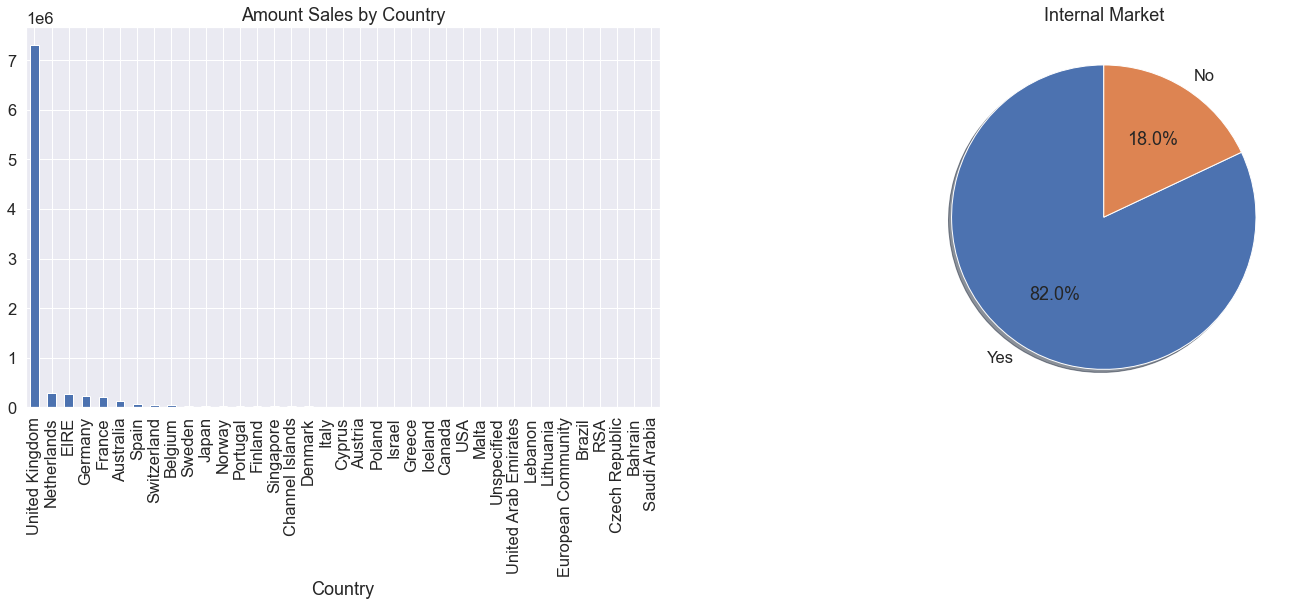

In [29]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
g = cs_df.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
cs_df['Internal'] = cs_df.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = cs_df.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal Market')
plt.show()

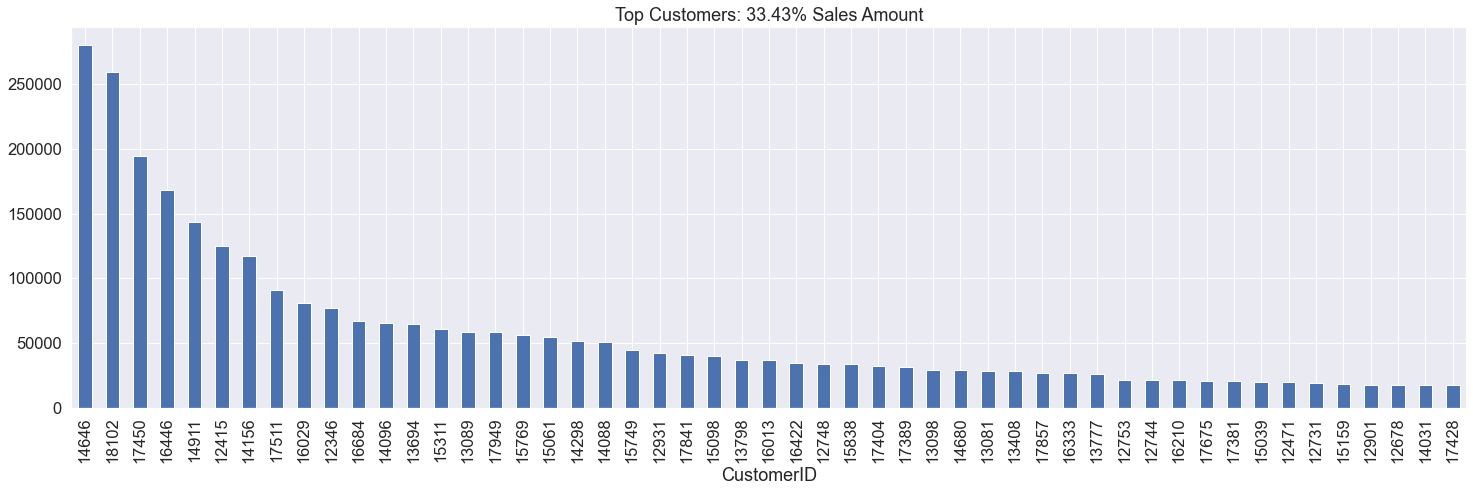

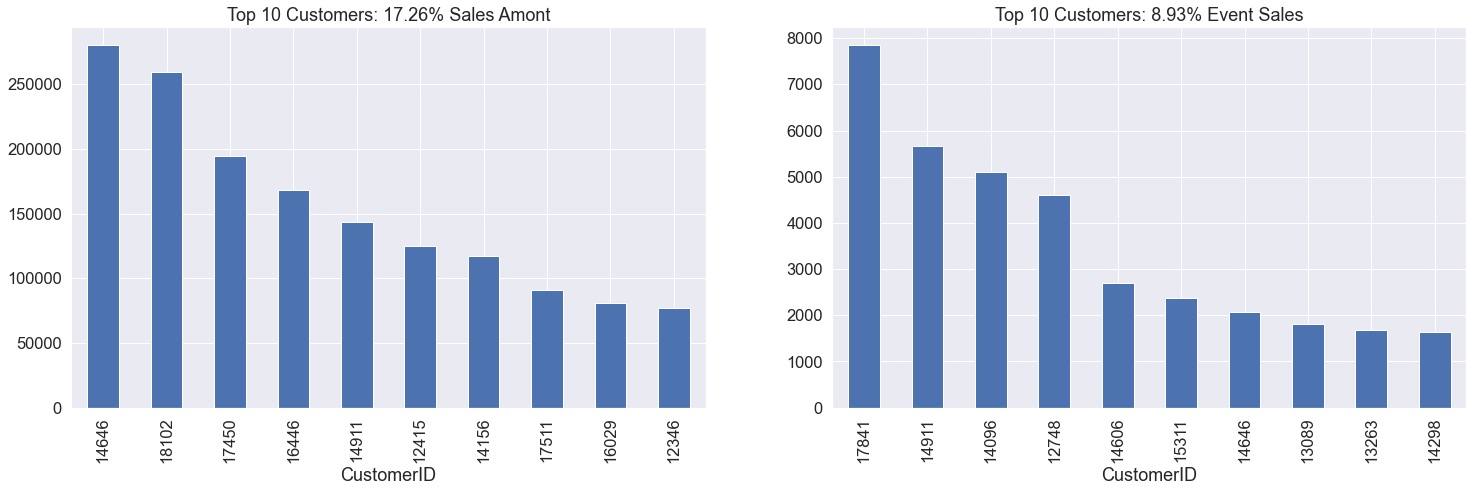

In [30]:
fig = plt.figure(figsize=(25, 7))
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))

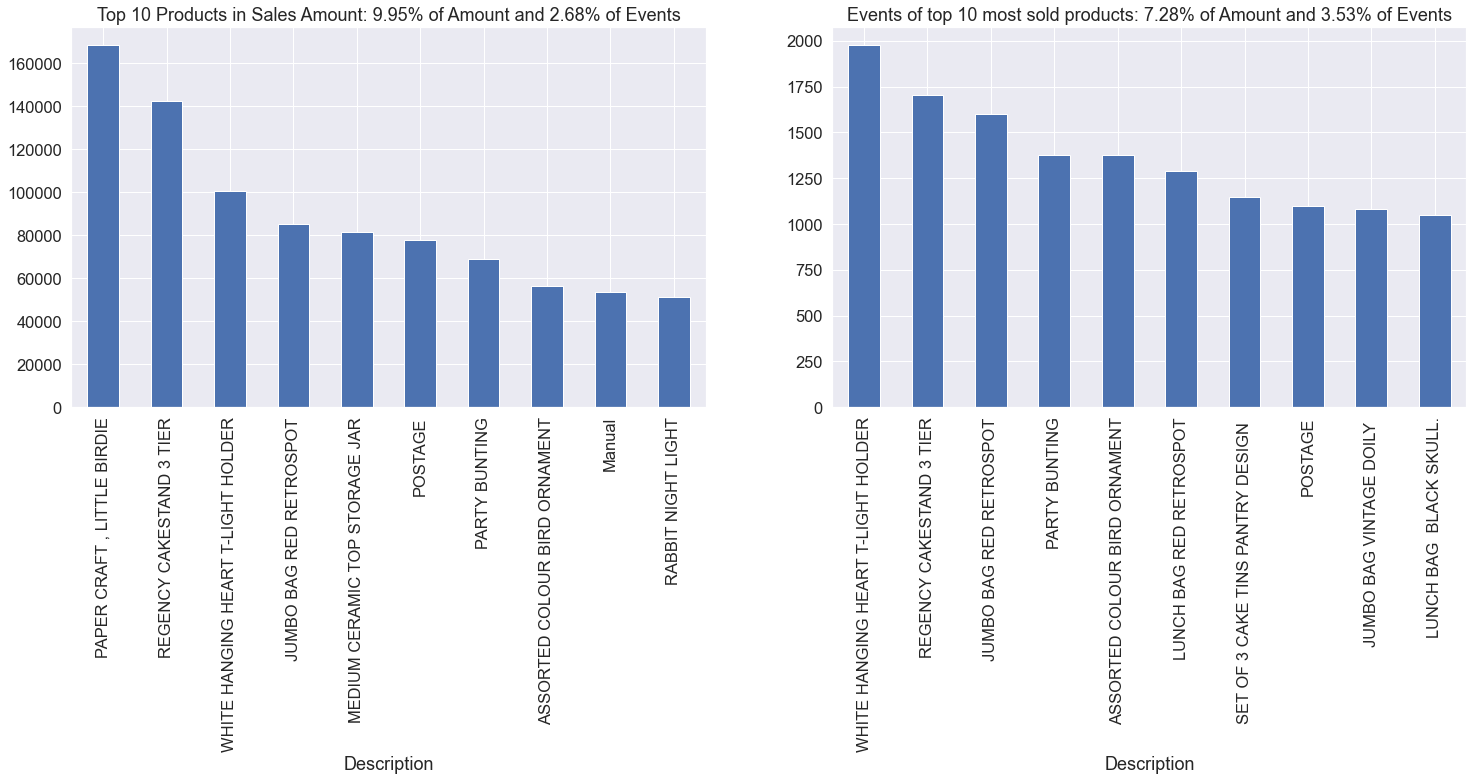

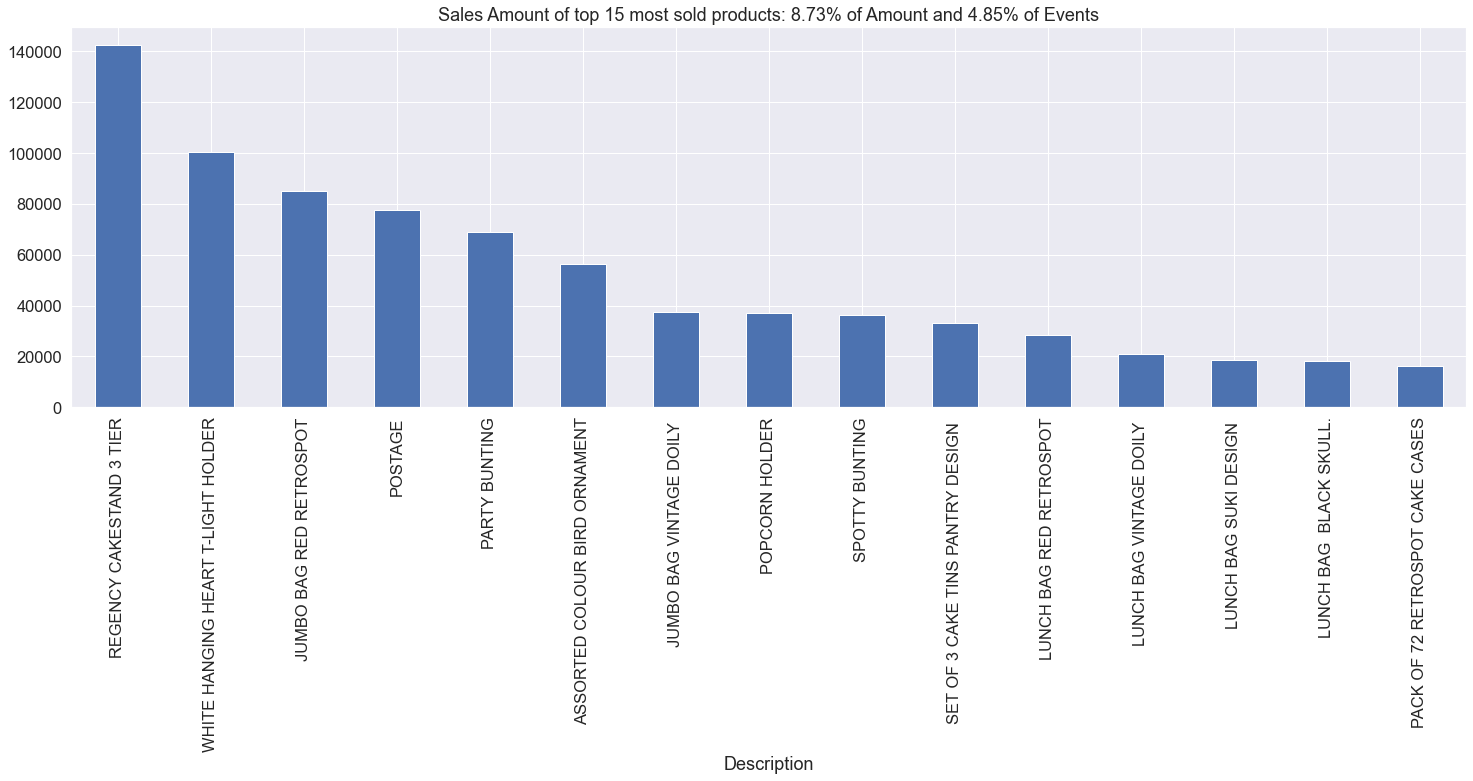

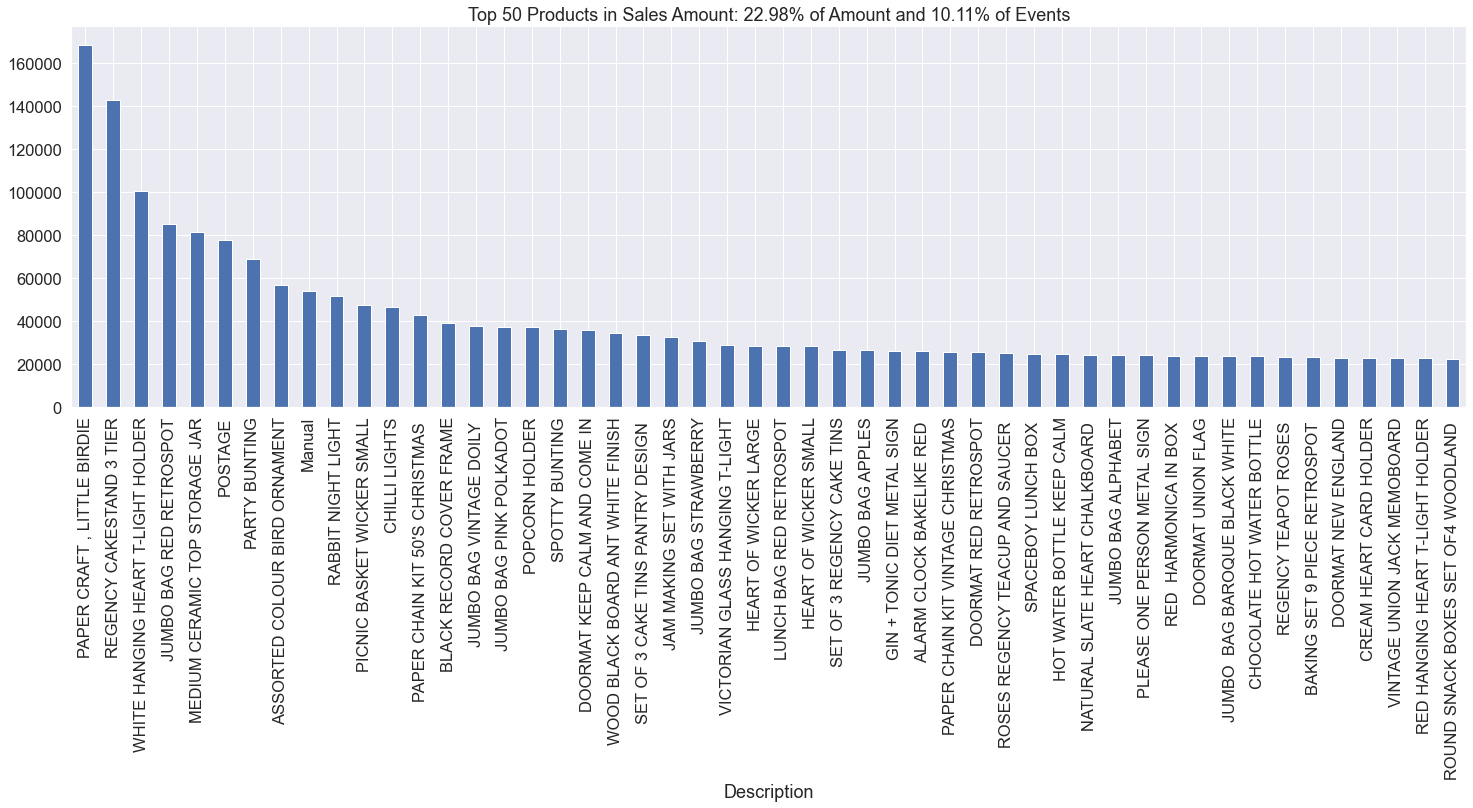

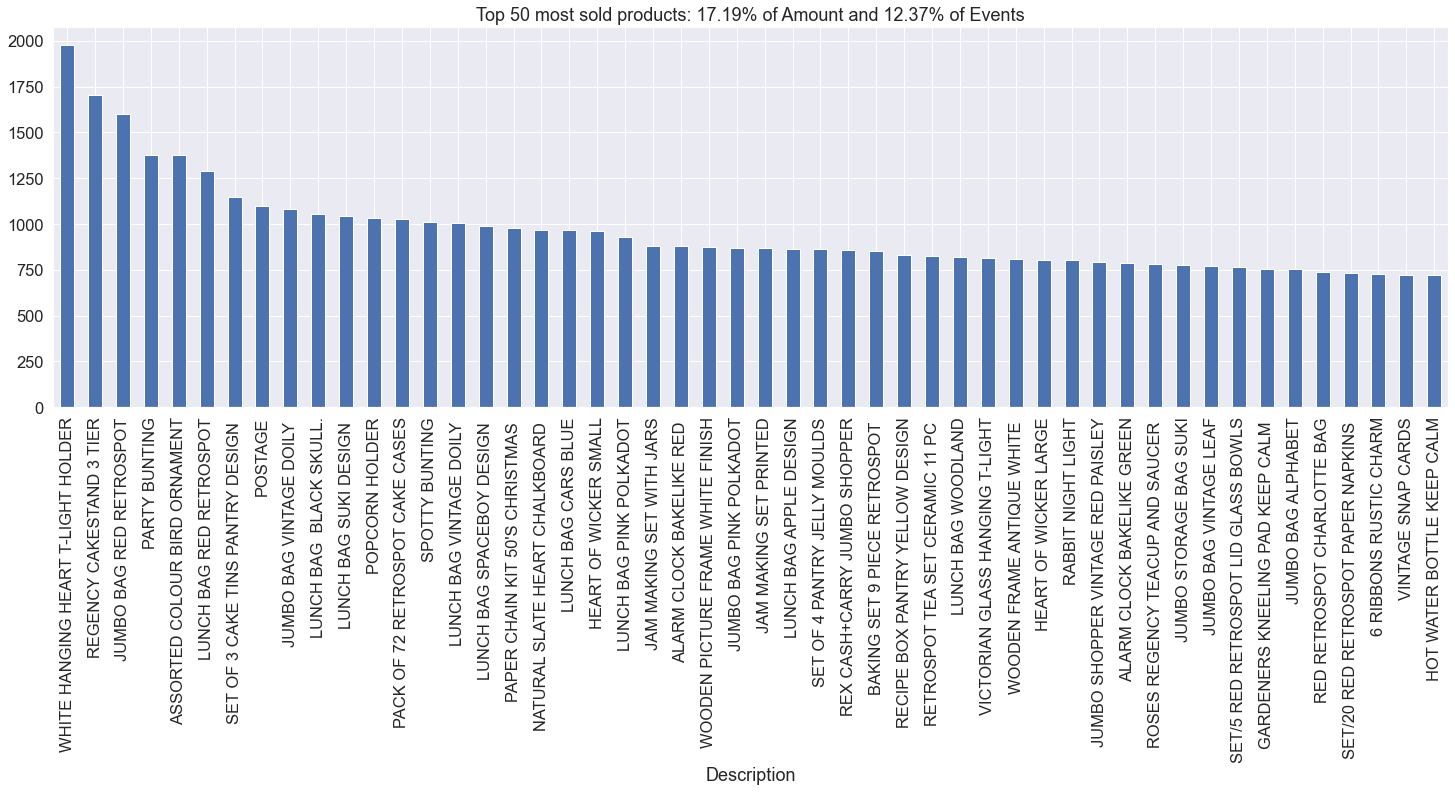

In [31]:
AmoutSum = cs_df.groupby(["Description"]).amount.sum().sort_values(ascending = False)
inv = cs_df[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
      agg(np.size).sort_values(ascending = False)

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(AmoutSum[:10].index)
PercentSales =  np.round((AmoutSum[Top10].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
PercentSales =  np.round((AmoutSum[Top10Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:15].index)
PercentSales =  np.round((AmoutSum[Top15ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top15ev].sort_values(ascending = False).\
    plot(kind='bar', 
         title='Sales Amount of top 15 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales =  np.round((AmoutSum[Top50].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top50].\
    plot(kind='bar', 
         title='Top 50 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:50].index)
PercentSales =  np.round((AmoutSum[Top50Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top50Ev].\
    plot(kind='bar', title='Top 50 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

## Customer Segmentation:

Segmentasi pelanggan juga merupakan proses membagi basis pelanggan organisasi menjadi bagian atau segmen yang berbeda berdasarkan berbagai atribut pelanggan. Proses segmentasi pelanggan didasarkan pada premis untuk menemukan perbedaan antara perilaku dan pola pelanggan.

Tujuan dan manfaat utama di balik motivasi segmentasi pelanggan adalah:

+ Pendapatan Lebih Tinggi: Ini adalah persyaratan paling jelas dari setiap proyek segmentasi pelanggan.
+ Pemahaman Pelanggan: Salah satu paradigma bisnis yang paling diterima secara luas adalah "kenali pelanggan Anda" dan segmentasi basis pelanggan memungkinkan pemisahan yang sempurna dari paradigma ini.
+ Target Pemasaran: Alasan yang paling terlihat untuk segmentasi pelanggan adalah kemampuan untuk memfokuskan upaya pemasaran secara efektif dan efisien. Jika perusahaan mengetahui segmen yang berbeda dari basis pelanggannya, ia dapat merancang kampanye pemasaran yang lebih baik yang dibuat khusus untuk segmen tersebut. Model segmentasi yang baik memungkinkan pemahaman yang lebih baik tentang kebutuhan pelanggan dan karenanya meningkatkan peluang keberhasilan setiap kampanye pemasaran yang dikembangkan oleh organisasi.
+ Penempatan Produk yang Optimal: Strategi segmentasi pelanggan yang baik juga dapat membantu perusahaan mengembangkan atau menawarkan produk baru, atau sekumpulan produk bersama-sama sebagai penawaran gabungan.
+ Menemukan Segmen Pelanggan Laten: Mencari tahu segmen pelanggan mana yang mungkin hilang untuk mengidentifikasi segmen pelanggan yang belum dimanfaatkan dengan berfokus pada kampanye pemasaran atau pengembangan bisnis baru.

## Clustering

Metode yang paling jelas untuk melakukan segmentasi pelanggan adalah menggunakan metode Unsupervised Machine Learning seperti pengelompokan. Metodenya sesederhana mengumpulkan sebanyak mungkin data tentang pelanggan dalam bentuk fitur atau atribut dan kemudian menemukan cluster yang berbeda yang dapat diperoleh dari data tersebut. Akhirnya, kita dapat menemukan ciri-ciri segmen pelanggan dengan menganalisis karakteristik klaster.

# Cross Selling

## Build Transaction Dataset

In [32]:
items = list(cs_df.Description.unique())
grouped = cs_df.groupby('InvoiceNo')
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo','Description']]
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
transaction_df = pd.DataFrame(new)

### Prune Dataset for frequently purchased items

Kami melihat di EDA sebelumnya bagaimana hanya segelintir item yang bertanggung jawab atas sebagian besar penjualan kami, jadi kami ingin memangkas kumpulan data kami untuk mencerminkan informasi ini. Untuk ini kami telah membuat fungsi prune_dataset di bawah ini, yang akan membantu kami mengurangi ukuran dataset kami berdasarkan kebutuhan kami. Fungsi ini dapat digunakan untuk melakukan tiga jenis pemangkasan:

+ Pruning based on percentage of total sales:: Parameter total_sales_perc akan membantu kami memilih jumlah item yang akan menjelaskan persentase penjualan yang diperlukan. Nilai default adalah 50% atau 0,5.

+ Pruning based on ranks of items:: Cara lain untuk melakukan pemangkasan adalah dengan menentukan peringkat awal dan akhir dari item yang ingin kita pangkas datasetnya.

+ Pruning based on list of features passed to the parameter TopCols.

Secara default, kami hanya akan mencari transaksi yang memiliki setidaknya dua item, karena transaksi dengan hanya satu item bertentangan dengan seluruh konsep penambangan aturan asosiasi.

In [33]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, 
                  start_item = None, end_item = None, TopCols = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',
                               item_count.columns[1]:'item_count'}, inplace=True)
    if TopCols: 
        input_df['total_items'] = input_df[TopCols].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[TopCols], item_count[item_count.item_name.isin(TopCols)]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]
    else:
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]

In [34]:
output_df, item_counts = prune_dataset(input_df=transaction_df, length_trans=2,start_item = 0, end_item = 15)
print('Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): {:.2f}'.format(AmoutSum[Top15ev].sum()))
print('Number of Sales Events:', output_df.shape[0])
print('Number of Products:', output_df.shape[1])

item_counts

Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): 778377.21
Number of Sales Events: 4664
Number of Products: 15


item_name  item_count
0   WHITE HANGING HEART T-LIGHT HOLDER        1978
1             REGENCY CAKESTAND 3 TIER        1703
2              JUMBO BAG RED RETROSPOT        1600
3                        PARTY BUNTING        1379
4        ASSORTED COLOUR BIRD ORNAMENT        1375
5              LUNCH BAG RED RETROSPOT        1289
6    SET OF 3 CAKE TINS PANTRY DESIGN         1146
7                              POSTAGE        1099
8             JUMBO BAG VINTAGE DOILY         1080
9              LUNCH BAG  BLACK SKULL.        1052
10              LUNCH BAG SUKI DESIGN         1043
11                      POPCORN HOLDER        1035
12     PACK OF 72 RETROSPOT CAKE CASES        1029
13                      SPOTTY BUNTING        1009
14            LUNCH BAG VINTAGE DOILY         1006

Jadi kami menemukan bahwa kami memiliki 15 item yang bertanggung jawab atas 8,73% dari jumlah penjualan dan hampir 5% dari peristiwa menghasilkan 4.664 transaksi yang memiliki item tersebut bersama dengan item lainnya. Langkah selanjutnya adalah mengubah data yang dipilih ini menjadi struktur data tabel yang diperlukan.

#### Association Rule Mining with FP Growth


Karena kita menggunakan kerangka Orage, kita masih harus mengonversinya ke struktur data Tabel dengan menyediakan metadata tentang kolom kita. Kita perlu mendefinisikan domain untuk setiap variabel kita. Domain berarti kumpulan nilai yang mungkin yang dapat digunakan oleh masing-masing variabel kita. Informasi ini akan disimpan sebagai metadata dan akan digunakan dalam transformasi data selanjutnya. Karena kolom kami hanya memiliki nilai biner, kami dapat dengan mudah membuat domain dengan menggunakan informasi ini.

In [37]:
input_assoc_rules = output_df
# Defined the data domain by specifying each variable as a DiscreteVariable having values as (0, 1)
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) \
                         for item in input_assoc_rules.columns])

# Then using this domain, we created our Table structure for our data
data_tran = Orange.data.Table.from_numpy(domain=domain_transac,  
                                         X=input_assoc_rules)

# Coding our input so that the entire domain is represented as binary variables
data_tran_en, mapping = OneHot.encode(data_tran, include_class=True)

#### Creating our rules

Kita perlu menentukan dua informasi untuk menghasilkan aturan kita: support dan convidence. Sepotong informasi penting adalah memulai dengan support yang lebih tinggi, karena support yang lebih rendah akan berarti jumlah item yang lebih sering dan karenanya waktu eksekusi yang lebih lama. Kami akan menentukan support minimum 0,01 dan melihat jumlah item yang sering kami dapatkan sebelum kami menentukan convidence dan menghasilkan aturan kami.

In [38]:
support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_en, support))
print('Items Set Size:', len(itemsets))

num of required transactions =  46
Items Set Size: 663273


Jadi kami mendapatkan 663.273 item set untuk hanya 15 item dan dukungan hanya 1%! Ini akan meningkat secara eksponensial jika kita mengurangi dukungan atau jika kita menambah jumlah item dalam dataset kita. Langkah selanjutnya adalah menentukan nilai kepercayaan dan menghasilkan aturan kami. Cuplikan kode berikut akan melakukan pembuatan aturan dan decoding aturan, dan kemudian mengompilasi semuanya dalam kerangka data yang rapi yang dapat kita gunakan untuk analisis lebih lanjut.

In [39]:
confidence = 0.6
rules_df = pd.DataFrame()
if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_tran, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

Raw rules data frame of 25247 rules generated


### Explore The Association Rule Created


Mari kita lihat apa yang kita dapatkan dalam 5 aturan pertama dengan convidence tertinggi:

In [40]:
dw = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 100
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['confidence', 'support', 'lift'],
                                                   ascending=False)).head()

consequent  \
20   JUMBO BAG VINTAGE DOILY    
133  LUNCH BAG VINTAGE DOILY    
134  LUNCH BAG VINTAGE DOILY    
131  LUNCH BAG VINTAGE DOILY    
21   JUMBO BAG VINTAGE DOILY    

                                                                                             antecedent  \
20                           JUMBO BAG RED RETROSPOT, LUNCH BAG RED RETROSPOT, LUNCH BAG VINTAGE DOILY    
133  LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG  BLACK SKULL., LUNCH BAG SUKI DESIGN    
134                           LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG SUKI DESIGN    
131                          LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG  BLACK SKULL.   
21                            JUMBO BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN , LUNCH BAG VINTAGE DOILY    

     support  confidence      lift  
20        60    0.909091  4.520256  
133       49    0.890909  4.596460  
134       48    0.888889  4.586037  
131       48    0.872727  4.502655  
21        48    0.872727  4.339446

Now, the first 5 higest support:

In [41]:
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['support', 'confidence', 'lift'],
                                                   ascending=False)).head()

consequent  \
123  LUNCH BAG VINTAGE DOILY    
28   JUMBO BAG VINTAGE DOILY    
92    LUNCH BAG RED RETROSPOT   
77    LUNCH BAG RED RETROSPOT   
4     JUMBO BAG RED RETROSPOT   

                                            antecedent  support  confidence  \
123  JUMBO BAG VINTAGE DOILY , LUNCH BAG RED RETROSPOT      154    0.777778   
28   LUNCH BAG VINTAGE DOILY , JUMBO BAG RED RETROSPOT      153    0.805263   
92    LUNCH BAG VINTAGE DOILY , LUNCH BAG SUKI DESIGN       149    0.668161   
77     LUNCH BAG  BLACK SKULL., LUNCH BAG SUKI DESIGN       142    0.601695   
4    JUMBO BAG VINTAGE DOILY , LUNCH BAG RED RETROSPOT      138    0.696970   

         lift  
123  4.012783  
28   4.003995  
92   2.672646  
77   2.406780  
4    2.688723

Biasanya, nilai a lift 1 menunjukkan bahwa kemungkinan terjadinya anteseden dan konsekuen bersama-sama tidak tergantung satu sama lain. Oleh karena itu, idenya adalah untuk mencari aturan yang memiliki lift lebih besar dari 1. Jadi, mari kita lihat berapa banyak aturan yang memiliki lift lebih besar dari 1, sama dengan 1 dan kurang dari satu:

In [42]:
rules_df.lift.apply(lambda x: 'Greater Than One' if x > 1 else 'One' \
                           if x == 0 else 'Less Than One').value_counts()

Greater Than One    25247
Name: lift, dtype: int64

So all rules are valid.

In [43]:
pd.options.display.max_colwidth = dw

Kesimpulan :

Seperti yang telah kita lihat, pembuatan aturan adalah proses yang sangat sederhana, tetapi sangat mahal secara komputasi, karena tumbuh secara eksponensial dengan bertambahnya himpunan item.

Secara keseluruhan, kami mencari keseimbangan yang tepat antara dukungan dan kepercayaan yang mengarah ke sejumlah aturan kuat yang masuk akal.

Di sisi lain, jika tujuannya adalah untuk mengidentifikasi langka tetapi dengan pola kepercayaan tinggi, kita harus melanjutkan seperti sebelumnya, dengan menetapkan tingkat dukungan yang rendah dan tingkat kepercayaan yang lebih tinggi, yang mengarah ke sejumlah besar aturan.

Dengan pemikiran ini, aturan dengan dukungan rendah dan kepercayaan tinggi kemudian akan menjadi target kami untuk studi lebih lanjut dan daripada menguraikan strategi untuk meningkatkan penjualan silang.